In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import numpy as np
from atl_module.geospatial_utils.raster_interaction import (
    query_raster,
    query_from_lines,
)
import matplotlib.pyplot as plt
from atl_module.bathymetry_extraction.refraction_correction import correct_refr
from atl_module.plotting import set_size

# aggregation functions

In [3]:
# defining some useful aggregation functions

rms_lambda = lambda x: np.sqrt(np.mean(np.square(x)))
mae_lambda = lambda x: np.mean(np.abs(x))

# this is just for by-trackline groupbys
def agg_photon_counts(arr):
    assert np.all(
        arr == arr[0]
    ), "the groupby must be by tracklines with identical values for `n_subsurf_points` and `n_total_points`"
    return arr[0]


# this dictionary can be unpacked into .agg() to create summary table with named columns. can only be used with the bathymetry points GDF since its based on the expected column names
unpackable_error_dict = {
    "RMS Error [m]": pd.NamedAgg(column="error", aggfunc=rms_lambda),
    "MAE [m]": pd.NamedAgg(column="error", aggfunc=mae_lambda),
    "Mean Error [M]": pd.NamedAgg(column="error", aggfunc=np.mean),
    # the total number of points for any grouping is the count of entries in the bathy points gdf
    # the column X, which is the latitude, its used because it always has a valid value
    "n bathy points": pd.NamedAgg(column="X", aggfunc="count"),
    # to get the number of subsurface photons, we can take the mean because it will be the same if we are averaging by site and unique trackline
    # uses a function that raises an error if the points aren't all the same
    # "n photons":pd.NamedAgg(column='n_total_points',aggfunc=agg_photon_counts),
    # "n subsurf photons":pd.NamedAgg(column='n_subsurf_points',aggfunc=agg_photon_counts)
}

# get all AOIs

In [4]:
aoidflist = []
for aoifile in glob("../data/test_sites/*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined = pd.concat(aoidflist)

# get all secchi depth points

In [5]:
secchi_pt_list = []
for file in glob("../data/test_sites/*/secchi_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    secchi_pt_list.append(df)

secchi_pt_combined = pd.concat(secchi_pt_list).reset_index(drop=True)

secchi_pt_combined = secchi_pt_combined.assign(
    X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
)

# get all tracklines

In [6]:
# tracklines_dflist = [gpd.read_file(file) for file in glob('../data/test_sites/*/tracklines')]

tracklinesdflist = []
for file in glob("../data/test_sites/*/tracklines"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    tracklinesdflist.append(df)

tracklines_combined = pd.concat(tracklinesdflist).reset_index(drop=True)
tracklines_combined = tracklines_combined.assign(
    date=pd.to_datetime(tracklines_combined.date).dt.date
)

tracklines_combined.sort_values("avg_ph_cou")

,file,beam,rgt,date,beam_type,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,geometry,site
819,processed_ATL03_20190115094052_02740207_005_01,gt1l,274,2019-01-15,strong,5,96.328679,1.000000,0.000000,184.521091,"LINESTRING (-157.83223 21.56362, -157.83208 21...",oahu5
504,processed_ATL03_20200713073941_02740807_005_01,gt2r,274,2020-07-13,weak,34,95.260816,1.147059,0.000000,6218.042512,"LINESTRING (-157.95395 21.27779, -157.95125 21...",oahu1
1121,processed_ATL03_20210507051755_06631101_005_01,gt3r,663,2021-05-07,strong,20,96.302326,1.150000,0.000000,638.312852,"LINESTRING (-158.28003 21.55493, -158.28069 21...",oahu8
431,processed_ATL03_20220531053325_10561501_005_02,gt2l,1056,2022-05-31,strong,216,96.222648,1.310185,0.000000,14332.084721,"LINESTRING (-81.14391 24.61500, -81.15778 24.7...",florida_keys
491,processed_ATL03_20200413115954_02740707_005_01,gt3l,274,2020-04-13,weak,55,95.813700,1.327273,0.000000,6129.874607,"LINESTRING (-157.97985 21.27356, -157.97778 21...",oahu1
...,...,...,...,...,...,...,...,...,...,...,...,...
984,processed_ATL03_20200606211436_11050701_005_01,gt1l,1105,2020-06-06,strong,209501,3.120823,2726.849695,0.000000,2851.411856,"LINESTRING (-158.20881 21.57528, -158.21371 21...",oahu7
1080,processed_ATL03_20200606211436_11050701_005_01,gt1l,1105,2020-06-06,strong,850030,3.120823,2727.128385,0.000000,9954.309631,"LINESTRING (-158.17409 21.37328, -158.18971 21...",oahu8
972,processed_ATL03_20190915220417_12190407_005_01,gt1l,1219,2019-09-15,weak,255324,0.000000,2882.606555,0.000000,3234.898573,"LINESTRING (-158.16393 21.57320, -158.16248 21...",oahu7
1084,processed_ATL03_20200606211436_11050701_005_01,gt3l,1105,2020-06-06,strong,216092,2.836104,3122.430442,0.000000,2382.689088,"LINESTRING (-158.10246 21.31773, -158.10621 21...",oahu8


# Concatenate all bathymetry points from all sites

In [10]:
dflist = []
for file in glob("../data/test_sites/*/all_bathy_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    dflist.append(df)

bathy_pts_df = pd.concat(dflist).reset_index(drop=True).dropna()

bathy_pts_df = bathy_pts_df.assign(date=pd.to_datetime(bathy_pts_df.delta_time).dt.date)

# looking into refraction correction

<AxesSubplot:xlabel='p_vec_elev', ylabel='p_vec_az'>

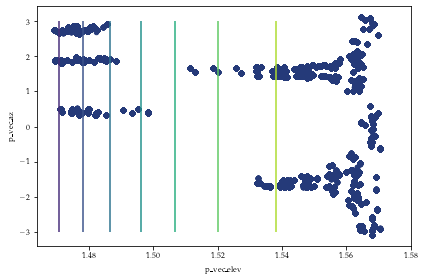

In [11]:
fig, ax = plt.subplots()

az_vecs = np.linspace(-3, 3, 1000)
elev_vecs = np.linspace(1.47, 1.58, 1000)
azgrid, elevgrid = np.meshgrid(az_vecs, elev_vecs)
xcorr, ycorr, zcorr = correct_refr(5, azgrid, elevgrid)

ax.contour(elevgrid, azgrid, zcorr)
bathy_pts_df.plot.scatter(x="p_vec_elev", y="p_vec_az", ax=ax)

In [12]:
el1 = bathy_pts_df.p_vec_elev.max()
az1 = bathy_pts_df.p_vec_az.iloc[bathy_pts_df.p_vec_elev.idxmax()]

In [13]:
correct_refr(10, el1, az1)

(7.236219752462812, 0.001997522355531652, -1.0123863696347617)

## Some stats about all the total batymetry points found

do we see a spike around 2.3 or 4.2 due to ringing?


In [14]:
# set bin edges to encapsulate the location where ringing occurs
binedges = np.arange(-25.05, 0.6, 0.1)
# 2.3 or 4.2 m

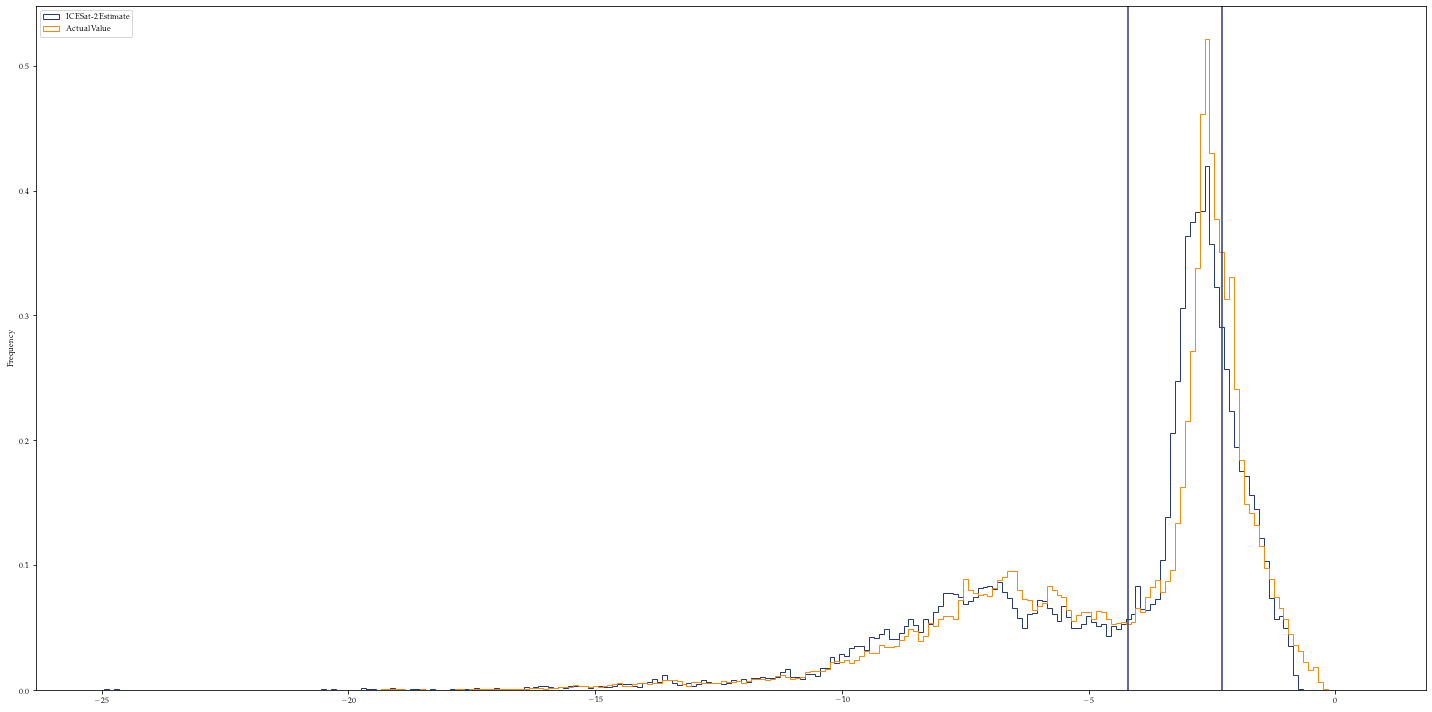

In [15]:
ax = bathy_pts_df.sf_elev_MSL.plot.hist(
    bins=binedges,
    histtype="step",
    density=True,
    label="ICESat-2 Estimate",
    figsize=(20, 10),
)
bathy_pts_df.true_elevation.plot.hist(
    ax=ax, bins=binedges, histtype="step", density=True, label="Actual Value"
)
# ax.set_xlim((-25,0))
ax.axvline(-2.3)
ax.axvline(-4.2)
ax.legend(loc="upper left")

In [16]:
error_by_site = bathy_pts_df.groupby("site").agg(**unpackable_error_dict).round(2)
error_by_site

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
site,,,,
charlotteamalie,1.08,0.56,-0.17,14214
florida_keys,0.83,0.32,0.21,261200
oahu1,1.16,0.77,0.54,3207
oahu2,10.60,1.45,1.41,4326
oahu3,1.24,0.46,0.30,18217
oahu4,0.75,0.57,0.41,2544
oahu5,0.73,0.50,0.27,10315
oahu6,2.42,1.76,-1.43,754
oahu7,1.11,0.72,-0.02,2890


based on the graph above we do not see significant deviation from the overall distribution of true bathymetry.

# Sites by Secchi Depth

In [17]:
secchi_pt_combined = secchi_pt_combined.assign(
    gebco_elev=query_raster(
        secchi_pt_combined.assign(
            X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
        ),
        "../data/GEBCO/GEBCO_2021_sub_ice_topo.nc",
    )
)
# mask out values based on GEBCO elevation
secchi_pt_combined = secchi_pt_combined[secchi_pt_combined.gebco_elev < 0]

In [18]:
zsd_date_beam = (
    secchi_pt_combined.dropna()
    .groupby(["site", secchi_pt_combined.date, "beam"])
    .median()
    .reset_index()
)

Text(0.5, 0.98, '')

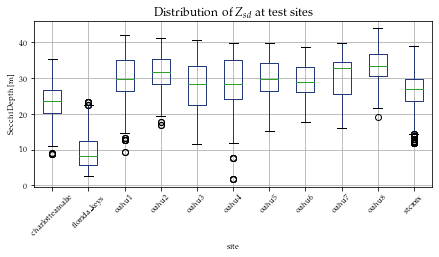

In [19]:
fig, ax = plt.subplots(figsize=set_size())
ax = secchi_pt_combined.boxplot(column="zsd", by="site", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Secchi Depth [m]")
ax.set_title("Distribution of $Z_{sd}$ at test sites")
fig.suptitle(None)

In [20]:
fig.savefig("../document/figures/secchi_by_site_boxplot.pdf")
# fig.savefig('../document/figures/secchi_by_site_boxplot.pgf',backend='pgf')

In [21]:
secchi_pt_combined.groupby("site").median().merge(
    error_by_site, left_index=True, right_index=True
)

,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,RMS Error [m],MAE [m],Mean Error [M],n bathy points
site,,,,,,,,,,,
charlotteamalie,23.515282,23.920000,0.039698,29.109999,-64.911919,18.345750,-31.0,1.08,0.56,-0.17,14214
florida_keys,8.286758,56.009998,0.095968,74.010002,-80.986446,24.744184,-3.0,0.83,0.32,0.21,261200
oahu1,29.702919,29.519999,0.033219,32.989998,-157.910539,21.276661,-40.0,1.16,0.77,0.54,3207
oahu2,31.586966,28.969999,0.031779,32.270000,-157.679485,21.270529,-47.0,10.60,1.45,1.41,4326
oahu3,28.434975,50.919998,0.034304,59.230000,-157.682220,21.363550,-29.0,1.24,0.46,0.30,18217
oahu4,28.425524,27.139999,0.034313,45.480000,-157.747833,21.474975,-45.0,0.75,0.57,0.41,2544
oahu5,29.843815,25.480000,0.033104,32.930000,-157.917571,21.672136,-34.0,0.73,0.50,0.27,10315
oahu6,28.927444,31.820000,0.033870,32.299999,-157.987923,21.718169,-39.5,2.42,1.76,-1.43,754
oahu7,32.762161,25.539999,0.030973,32.254999,-158.191102,21.599575,-32.0,1.11,0.72,-0.02,2890


The code below makes the table prettier by dropping extraneous columns, renaming the sites to actual names instead of filenames, and adding latex formatted table anmes

In [24]:
# tracklines_by_site = tracklines_combined.groupby(["site"]).median()
tracklines_by_site = (
    secchi_pt_combined.groupby("site")
    .median()
    .merge(error_by_site, left_index=True, right_index=True)
    .drop(columns=["X", "Y", "gebco_elev", "diff_atten", "diff_atten_unc"])
)
namelist = [
    "Charlotte Amalie",
    "Florida Keys",
    "Oahu 1",
    "Oahu 2",
    "Oahu 3",
    "Oahu 4",
    "Oahu 5",
    "Oahu 6",
    "Oahu 7",
    "Oahu 8",
    "St. Croix",
]

tracklines_by_site["Site Name"] = namelist
output_table = (
    tracklines_by_site.round(4)
    .set_index("Site Name")
    .rename(
        columns={
            "zsd": "$Zsd_{50}$[m]",
            "sigma_zsd": "$Zsd_{50}$ uncertainty",
            "diff_atten": "Median $Kd_{490}$",
            "diff_atten_unc": "median $Kd_{490}$ uncertainty",
        }
    )
)
output_table

,$Zsd_{50}$[m],$Zsd_{50}$ uncertainty,RMS Error [m],MAE [m],Mean Error [M],n bathy points
Site Name,,,,,,
Charlotte Amalie,23.5153,23.92,1.08,0.56,-0.17,14214
Florida Keys,8.2868,56.01,0.83,0.32,0.21,261200
Oahu 1,29.7029,29.52,1.16,0.77,0.54,3207
Oahu 2,31.5870,28.97,10.60,1.45,1.41,4326
Oahu 3,28.4350,50.92,1.24,0.46,0.30,18217
Oahu 4,28.4255,27.14,0.75,0.57,0.41,2544
Oahu 5,29.8438,25.48,0.73,0.50,0.27,10315
Oahu 6,28.9274,31.82,2.42,1.76,-1.43,754
Oahu 7,32.7622,25.54,1.11,0.72,-0.02,2890


In [25]:
output_table.to_latex(
    "../document/tables/secchi_site.tex",
    float_format="%.2f",
    escape=False,
    label="tab:ocean_color_summary_by_site",
    caption="Secchi Depth and RMSE for each site",
)

/tmp/ipykernel_1409/4188188656.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  output_table.to_latex(


# Analysis of tracklines by site
going to start from scratch

In [26]:
bathy_pts_df.groupby(["site", "date", "beam"]).agg(np.mean)

X          Y    Z_ellip    Z_geoid  \
site            date       beam                                               
charlotteamalie 2018-11-22 gt1l -64.909433  18.405369 -56.129138 -11.564461   
                           gt1r -64.915244  18.357089 -54.897201 -10.456566   
                           gt2l -64.947799  18.327885 -50.609892  -6.254161   
                           gt2r -64.949534  18.318636 -51.783983  -7.427204   
                           gt3l -64.976783  18.341017 -49.128370  -4.748831   
...                                    ...        ...        ...        ...   
stcroix         2021-12-15 gt1r -64.847951  17.669176 -52.092978  -8.489442   
                           gt2l -64.877354  17.669371 -52.564237  -8.872614   
                           gt2r -64.877940  17.671653 -51.765971  -8.064654   
                2022-03-15 gt2l -64.764100  17.672771 -58.796830 -15.271503   
                           gt3l -64.794097  17.675386 -54.989821 -11.446517   

                                 geoid_corr  tide_ocean_corr  geof2m_corr  \
site            date       beam                                             
charlotteamalie 2018-11-22 gt1l  -44.655016        -0.183779     0.090339   
                           gt1r  -44.531168        -0.172846     0.090533   
                           gt2l  -44.446381        -0.167639     0.090650   
                           gt2r  -44.447465        -0.165500     0.090687   
                           gt3l  -44.470136        -0.172252     0.090597   
...                                     ...              ...          ...   
stcroix         2021-12-15 gt1r  -43.696786        -0.083813     0.093250   
                           gt2l  -43.784873        -0.083550     0.093249   
                           gt2r  -43.794558        -0.083550     0.093240   
                2022-03-15 gt2l  -43.618563        -0.005797     0.093236   
                           gt3l  -43.636530        -0.005993     0.093226   

                                 oc_sig_conf  land_sig_conf  p_vec_az  ...  \
site            date       beam                                        ...   
charlotteamalie 2018-11-22 gt1l     3.636364       3.636364 -1.568716  ...   
                           gt1r     3.892086       3.920863 -1.933917  ...   
                           gt2l     2.166667       3.735294 -1.634106  ...   
                           gt2r     1.840000       3.875556 -2.264461  ...   
                           gt3l     3.421875       3.562500  2.612902  ...   
...                                      ...            ...       ...  ...   
stcroix         2021-12-15 gt1r     2.551622       3.607670  1.742342  ...   
                           gt2l     2.880562       3.956674  1.491413  ...   
                           gt2r     2.684825       3.856031  1.710539  ...   
                2022-03-15 gt2l     0.408163       0.380952  0.583314  ...   
                           gt3l     1.186100       1.077858  1.318850  ...   

                                  kde_val  oc_hconf_perc  n_subsurf_points  \
site            date       beam                                              
charlotteamalie 2018-11-22 gt1l  0.105156      94.712824             451.0   
                           gt1r  0.150415      96.346765            1745.0   
                           gt2l  0.136556      94.710615             656.0   
                           gt2r  0.120523      96.456881            1928.0   
                           gt3l  0.121838      95.118919             569.0   
...                                   ...            ...               ...   
stcroix         2021-12-15 gt1r  0.180389      96.247639             984.0   
                           gt2l  0.131014      96.336958            2128.0   
                           gt2r  0.131747      96.163232             653.0   
                2022-03-15 gt2l  0.106341      51.849537            2145.0   
                           gt3l  0.116321      55.786161    

In [27]:
error_by_transect = bathy_pts_df.groupby(["site", "date", "beam"]).agg(
    **unpackable_error_dict
)
error_by_transect

RMS Error [m]   MAE [m]  Mean Error [M]  \
site            date       beam                                            
charlotteamalie 2018-11-22 gt1l       0.917383  0.799143        0.381374   
                           gt1r       0.466839  0.340227        0.164312   
                           gt2l       3.650315  2.566434       -2.116037   
                           gt2r       1.973258  1.268536       -0.682158   
                           gt3l       0.148725  0.097550        0.069846   
...                                        ...       ...             ...   
stcroix         2021-12-15 gt1r       1.729840  1.318498       -1.088719   
                           gt2l       0.657330  0.432050       -0.171566   
                           gt2r       0.781079  0.526942       -0.092972   
                2022-03-15 gt2l       0.993448  0.959139        0.959139   
                           gt3l       0.366838  0.294623       -0.177783   

                                 n bathy points  
site            date       beam                  
charlotteamalie 2018-11-22 gt1l              11  
                           gt1r             417  
                           gt2l             102  
                           gt2r             225  
                           gt3l              64  
...                                         ...  
stcroix         2021-12-15 gt1r             339  
                           gt2l             854  
                           gt2r             257  
                2022-03-15 gt2l             147  
                           gt3l            2633  

[462 rows x 4 columns]

In [28]:
final_trackline_summary = tracklines_combined.merge(
    error_by_transect, on=["site", "date", "beam"], how="left"
).replace({"n bathy points": np.NaN}, value=0)

final_trackline_summary["ph_per_m"] = (
    final_trackline_summary.n_photons / final_trackline_summary["length"]
)

In [29]:
bathy_pts_df.groupby("beamtype").agg(**unpackable_error_dict)

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
beamtype,,,,
strong,0.837984,0.350087,0.169139,350113
weak,3.080986,0.473164,0.135537,53844


In [30]:
final_trackline_summary.groupby(final_trackline_summary["n bathy points"] == 0).mean()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
n bathy points,,,,,,,,,,
False,50493.077922,83.747683,124.408923,0.006909,13369.575487,1.069269,0.91899,0.257852,874.365801,3.910839
True,79704.347826,49.644514,321.979808,0.005037,8885.540619,NaN,NaN,NaN,0.000000,9.971971


In [31]:
final_trackline_summary

,file,beam,rgt,date,beam_type,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,geometry,site,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
0,processed_ATL03_20181118180604_07810101_005_01,gt1l,781,2018-11-18,weak,57485,5.200868,148.215500,0.000046,13661.191363,"LINESTRING (-65.05330 18.29592, -65.06601 18.4...",charlotteamalie,NaN,NaN,NaN,0.0,4.207905
1,processed_ATL03_20181118180604_07810101_005_01,gt1r,781,2018-11-18,strong,75310,68.725040,131.635878,0.000000,13680.730945,"LINESTRING (-65.05262 18.29581, -65.06537 18.4...",charlotteamalie,NaN,NaN,NaN,0.0,5.504823
2,processed_ATL03_20181118180604_07810101_005_01,gt2l,781,2018-11-18,weak,52136,7.932656,94.177862,0.000048,14462.224446,"LINESTRING (-65.02239 18.29047, -65.03585 18.4...",charlotteamalie,NaN,NaN,NaN,0.0,3.604978
3,processed_ATL03_20181118180604_07810101_005_01,gt2r,781,2018-11-18,strong,64474,62.957850,110.641437,0.000000,14483.648451,"LINESTRING (-65.02169 18.29035, -65.03518 18.4...",charlotteamalie,NaN,NaN,NaN,0.0,4.451503
4,processed_ATL03_20181118180604_07810101_005_01,gt3l,781,2018-11-18,weak,58996,2.100001,124.933606,0.000042,15263.922124,"LINESTRING (-64.99149 18.28502, -65.00567 18.4...",charlotteamalie,NaN,NaN,NaN,0.0,3.865062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,processed_ATL03_20220315201713_12761407_005_01,gt1r,1276,2022-03-15,weak,48147,2.183704,128.155524,0.000078,18924.447299,"LINESTRING (-64.73909 17.62984, -64.72144 17.7...",stcroix,NaN,NaN,NaN,0.0,2.544169
1332,processed_ATL03_20220315201713_12761407_005_01,gt2l,1276,2022-03-15,strong,315773,51.849537,548.077090,0.003100,20842.088629,"LINESTRING (-64.76858 17.62954, -64.74916 17.8...",stcroix,0.993448,0.959139,0.959139,147.0,15.150737
1333,processed_ATL03_20220315201713_12761407_005_01,gt2r,1276,2022-03-15,weak,117079,4.900382,242.992484,0.013580,20306.917716,"LINESTRING (-64.76942 17.62944, -64.75051 17.8...",stcroix,NaN,NaN,NaN,0.0,5.765474
1334,processed_ATL03_20220315201713_12761407_005_01,gt3l,1276,2022-03-15,strong,380147,55.786161,763.082147,0.000112,20880.586849,"LINESTRING (-64.79888 17.62915, -64.77940 17.8...",stcroix,0.366838,0.294623,-0.177783,2633.0,18.205762


<AxesSubplot:xlabel='avg_ph_cou', ylabel='RMS Error [m]'>

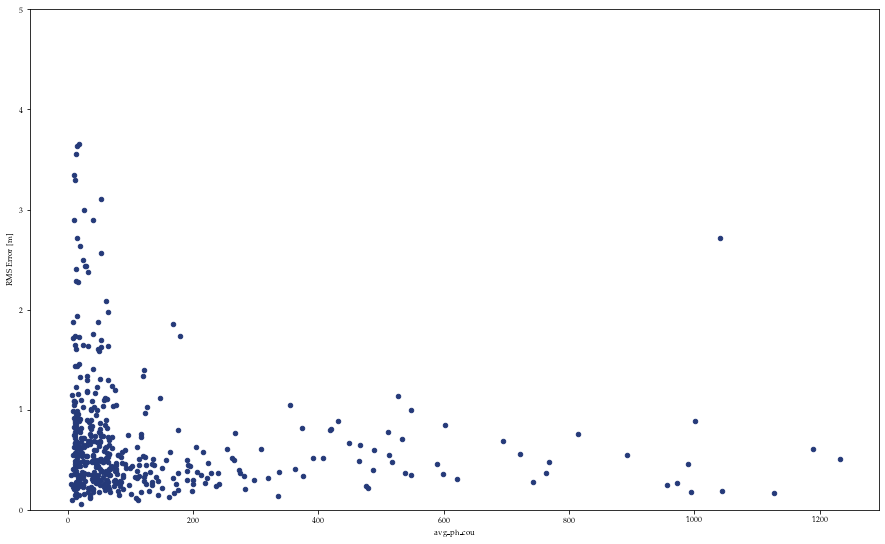

In [32]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="avg_ph_cou", figsize=set_size(fraction=2), ylim=(0, 5)
)

<AxesSubplot:xlabel='avg_ph_cou', ylabel='n bathy points'>

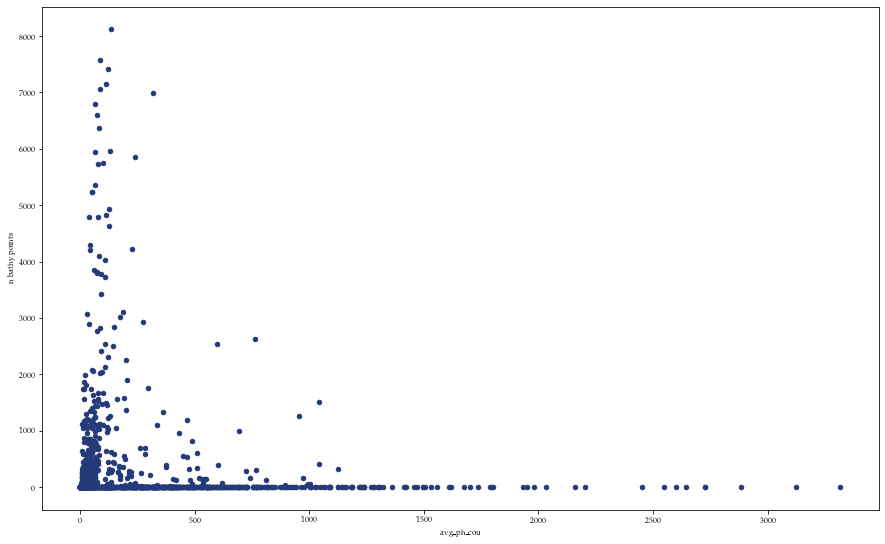

In [33]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="avg_ph_cou", figsize=set_size(fraction=2)
)

<AxesSubplot:xlabel='ph_per_m', ylabel='n bathy points'>

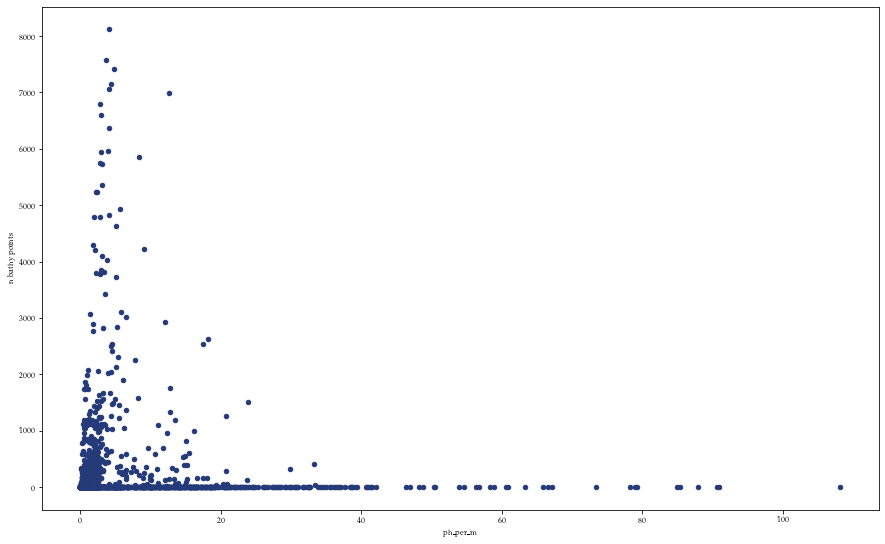

In [34]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="ph_per_m", figsize=set_size(fraction=2)
)

<AxesSubplot:xlabel='p_hconf', ylabel='n bathy points'>

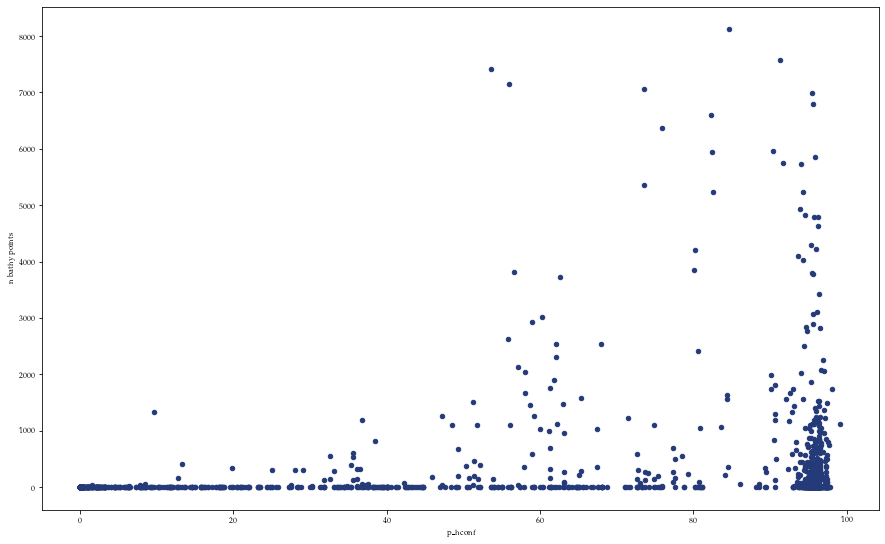

In [35]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="p_hconf", figsize=set_size(fraction=2)
)

<AxesSubplot:xlabel='avg_fsat', ylabel='n bathy points'>

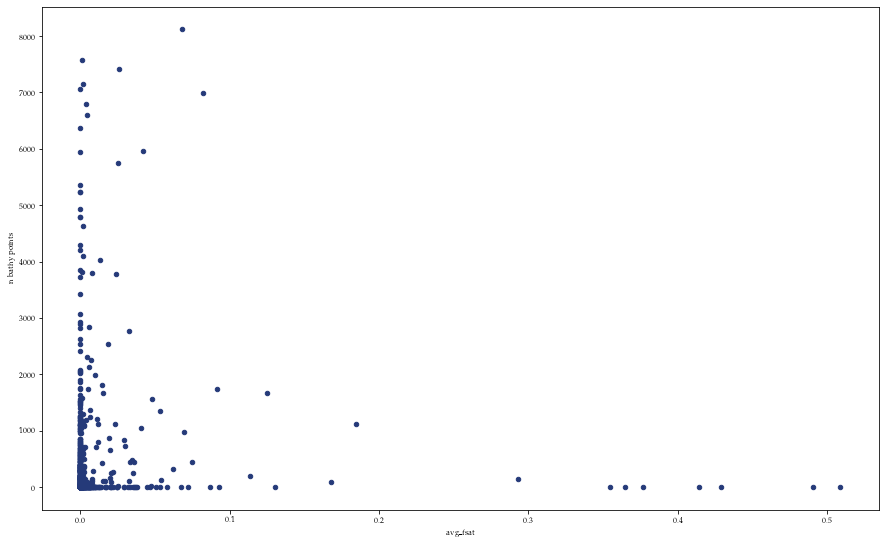

In [36]:
final_trackline_summary.plot.scatter(
    y="n bathy points", x="avg_fsat", figsize=set_size(fraction=2)
)

<AxesSubplot:xlabel='p_hconf', ylabel='RMS Error [m]'>

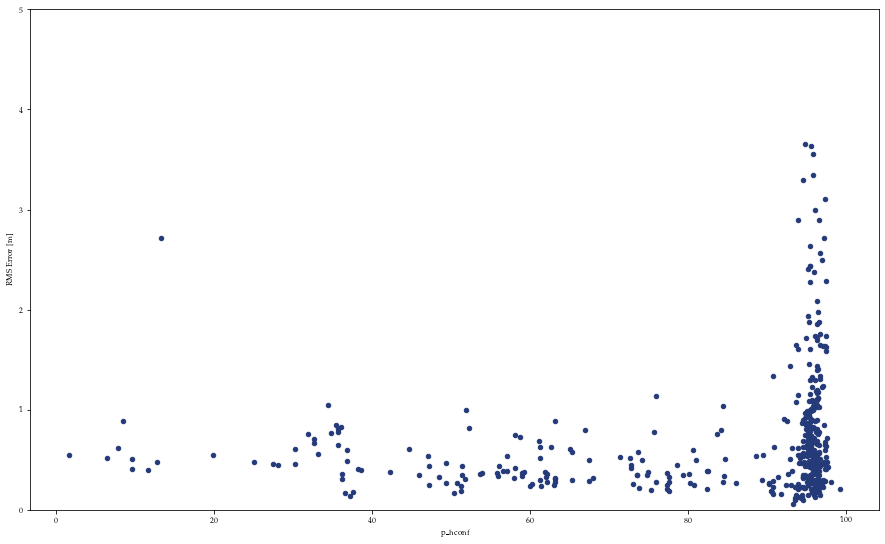

In [37]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="p_hconf", figsize=set_size(fraction=2), ylim=(0, 5)
)

<AxesSubplot:xlabel='avg_fsat', ylabel='RMS Error [m]'>

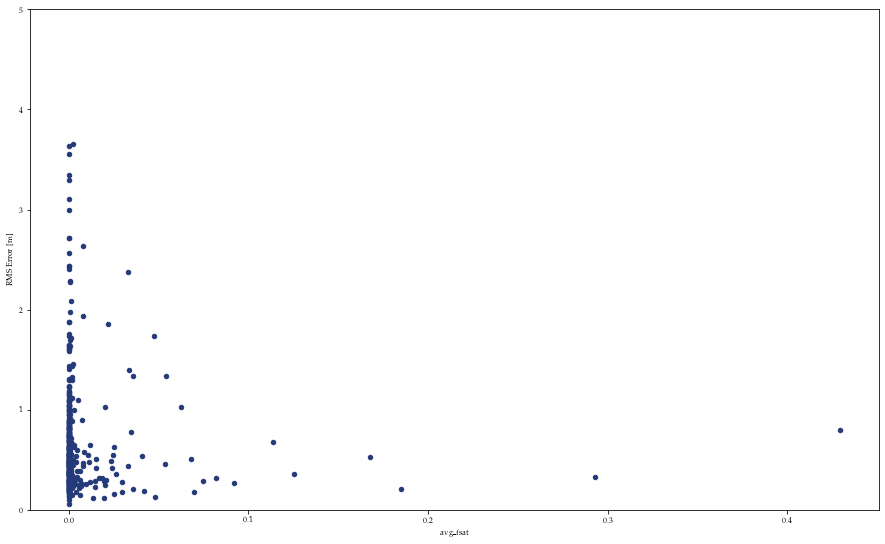

In [38]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="avg_fsat", figsize=set_size(fraction=2), ylim=(0, 5)
)

<AxesSubplot:xlabel='ph_per_m', ylabel='RMS Error [m]'>

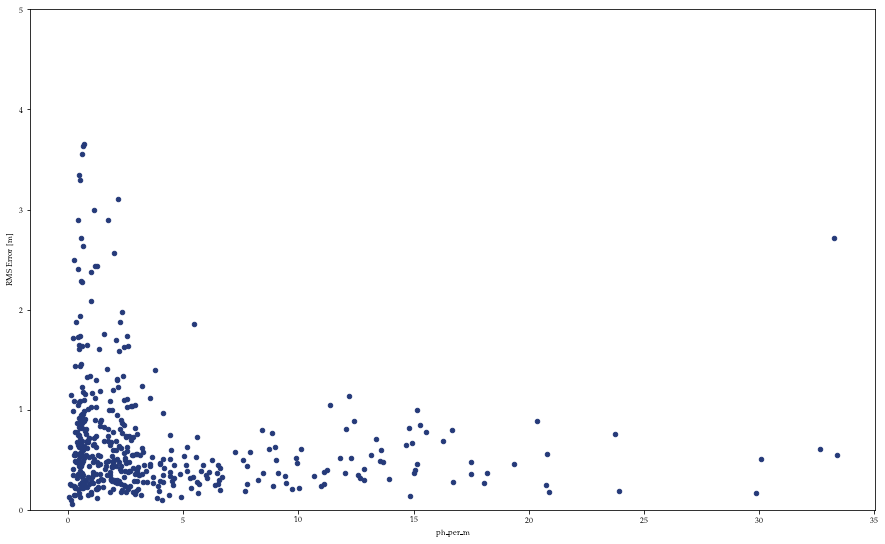

In [39]:
final_trackline_summary.plot.scatter(
    y="RMS Error [m]", x="ph_per_m", figsize=set_size(fraction=2), ylim=(0, 5)
)

In [40]:
final_trackline_summary.corr()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
n_photons,1.000000,-0.479368,0.752259,0.031428,0.182273,-0.027337,-0.021725,0.027494,-0.018200,0.789375
p_hconf,-0.479368,1.000000,-0.578294,0.045174,0.099546,-0.149752,-0.157361,-0.210832,0.190511,-0.575918
avg_ph_cou,0.752259,-0.578294,1.000000,-0.029919,-0.155893,0.070871,0.076121,0.116563,-0.107716,0.944592
avg_fsat,0.031428,0.045174,-0.029919,1.000000,0.125159,-0.018672,-0.016285,-0.002881,0.037481,-0.024821
length,0.182273,0.099546,-0.155893,0.125159,1.000000,-0.105121,-0.106330,-0.051288,0.276588,-0.176641
RMS Error [m],-0.027337,-0.149752,0.070871,-0.018672,-0.105121,1.000000,0.999465,0.862747,-0.064027,0.038402
MAE [m],-0.021725,-0.157361,0.076121,-0.016285,-0.106330,0.999465,1.000000,0.864405,-0.059830,0.044119
Mean Error [M],0.027494,-0.210832,0.116563,-0.002881,-0.051288,0.862747,0.864405,1.000000,-0.009993,0.089970
n bathy points,-0.018200,0.190511,-0.107716,0.037481,0.276588,-0.064027,-0.059830,-0.009993,1.000000,-0.095503
ph_per_m,0.789375,-0.575918,0.944592,-0.024821,-0.176641,0.038402,0.044119,0.089970,-0.095503,1.000000


In [41]:
final_trackline_summary.cov()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
n_photons,1.138617e+10,-1.993011e+06,3.212495e+07,114.903216,1.127020e+08,-11495.337499,-9065.106718,11585.433351,-1.818458e+06,1.037011e+06
p_hconf,-1.993011e+06,1.518109e+03,-9.017493e+03,0.061753,2.247495e+04,-18.489474,-19.279157,-26.085109,6.950457e+03,-2.762634e+02
avg_ph_cou,3.212495e+07,-9.017493e+03,1.601666e+05,-0.420045,-3.615222e+05,81.674568,87.049122,134.612705,-4.036531e+04,4.654157e+03
avg_fsat,1.149032e+02,6.175284e-02,-4.200449e-01,0.001229,2.540414e+01,-0.003360,-0.002908,-0.000519,1.199836e+00,-1.045723e-02
length,1.127020e+08,2.247495e+04,-3.615222e+05,25.404142,3.357708e+07,-3262.897584,-3275.002497,-1595.275124,1.500709e+06,-1.260157e+04
RMS Error [m],-1.149534e+04,-1.848947e+01,8.167457e+01,-0.003360,-3.262898e+03,32.632032,32.363303,28.211934,-5.221149e+02,1.174358e+00
MAE [m],-9.065107e+03,-1.927916e+01,8.704912e+01,-0.002908,-3.275002e+03,32.363303,32.131178,28.048403,-4.841329e+02,1.338776e+00
Mean Error [M],1.158543e+04,-2.608511e+01,1.346127e+02,-0.000519,-1.595275e+03,28.211934,28.048403,32.768378,-8.166020e+01,2.757064e+00
n bathy points,-1.818458e+06,6.950457e+03,-4.036531e+04,1.199836,1.500709e+06,-522.114875,-484.132863,-81.660200,8.767658e+05,-1.100951e+03
ph_per_m,1.037011e+06,-2.762634e+02,4.654157e+03,-0.010457,-1.260157e+04,1.174358,1.338776,2.757064,-1.100951e+03,1.515729e+02


In [42]:
final_trackline_summary.columns

Index(['file', 'beam', 'rgt', 'date', 'beam_type', 'n_photons', 'p_hconf',
       'avg_ph_cou', 'avg_fsat', 'length', 'geometry', 'site', 'RMS Error [m]',
       'MAE [m]', 'Mean Error [M]', 'n bathy points', 'ph_per_m'],
      dtype='object')

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

In [44]:
final_trackline_summary.count()

file              1336
beam              1336
rgt               1336
date              1336
beam_type         1336
n_photons         1336
p_hconf           1336
avg_ph_cou        1336
avg_fsat          1248
length            1336
geometry          1336
site              1336
RMS Error [m]      462
MAE [m]            462
Mean Error [M]     462
n bathy points    1336
ph_per_m          1336
dtype: int64

In [45]:
# get the dependant variables and standardize them from 0-1
x = final_trackline_summary.loc[
    :, ["n_photons", "p_hconf", "avg_ph_cou", "length", "n bathy points", "ph_per_m"]
].to_numpy()
x = StandardScaler().fit_transform(x)

# get the dependant variable
y = final_trackline_summary.loc[:, "n bathy points"].to_numpy() <= 5

pcs = PCA(
    n_components=2,
).fit_transform(x)

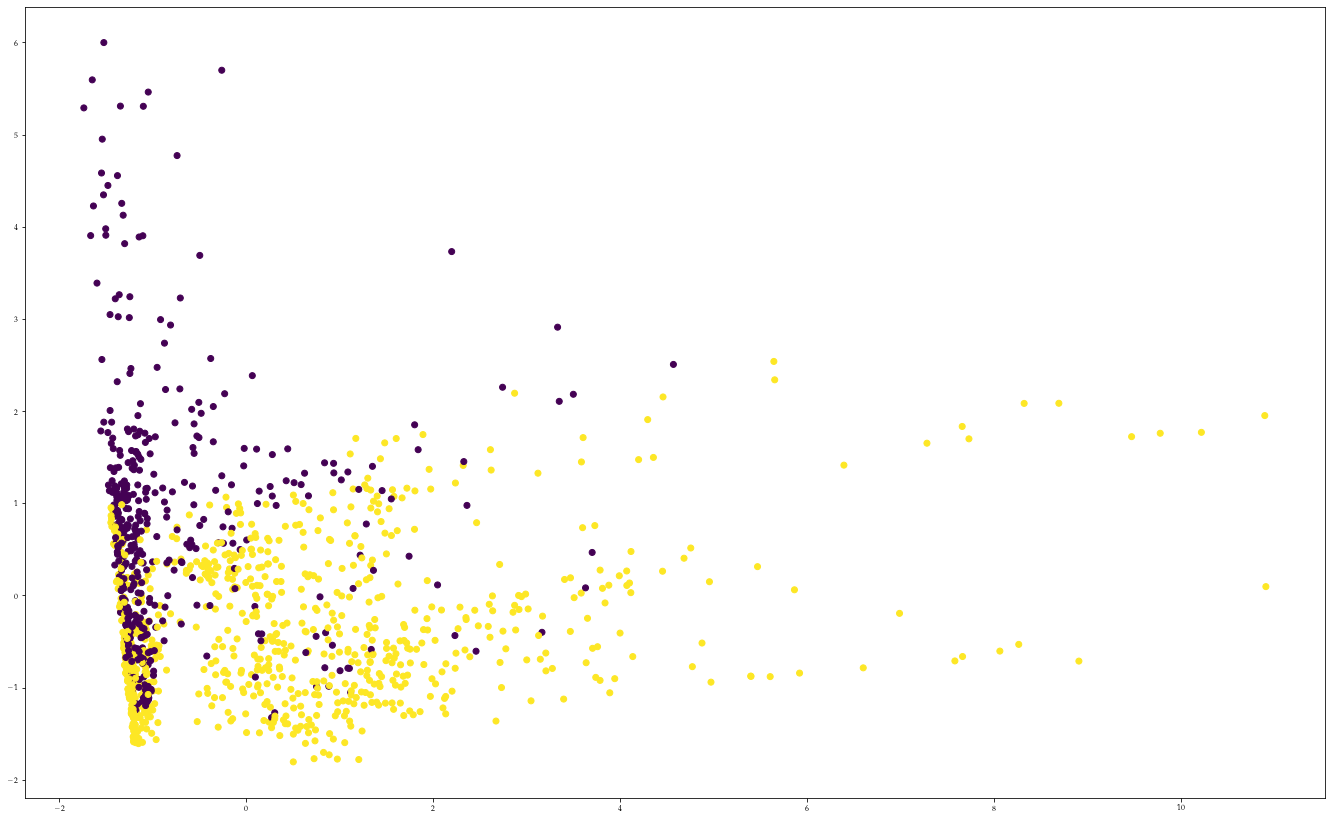

In [46]:
fig, ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs[:, 0], pcs[:, 1], c=y)

# PCA for each point to identify error

In [47]:
columns_of_interest = [
    "ph_count",
    "gebco_elev",
    "sea_level_interp",
    "sea_level_std_dev",
    "kde_val",
    "beamtype",
    "oc_hconf_perc",
    "n_subsurf_points",
    "n_total_points",
]

x = (
    bathy_pts_df.assign(beamtype=(bathy_pts_df.beamtype == "weak").astype("int"))
    .loc[:, columns_of_interest]
    .to_numpy()
)
x = StandardScaler().fit_transform(x)

# get the dependant variable
y = bathy_pts_df.loc[:, "error_abs"].to_numpy()

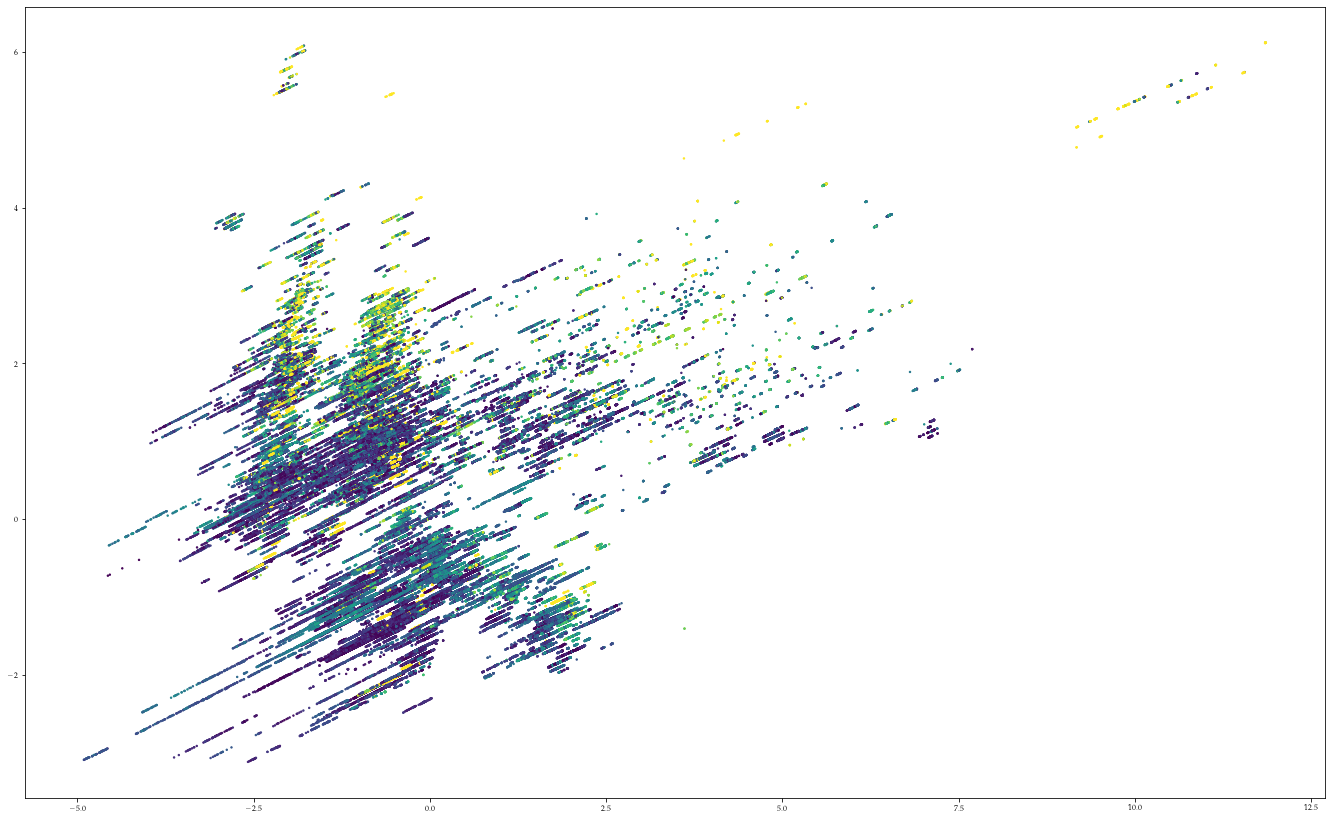

In [48]:
pcs = TruncatedSVD(n_components=2).fit_transform(x)

fig, ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs[:, 0], pcs[:, 1], c=y, s=2, vmax=1)

(0.0, 1.0)

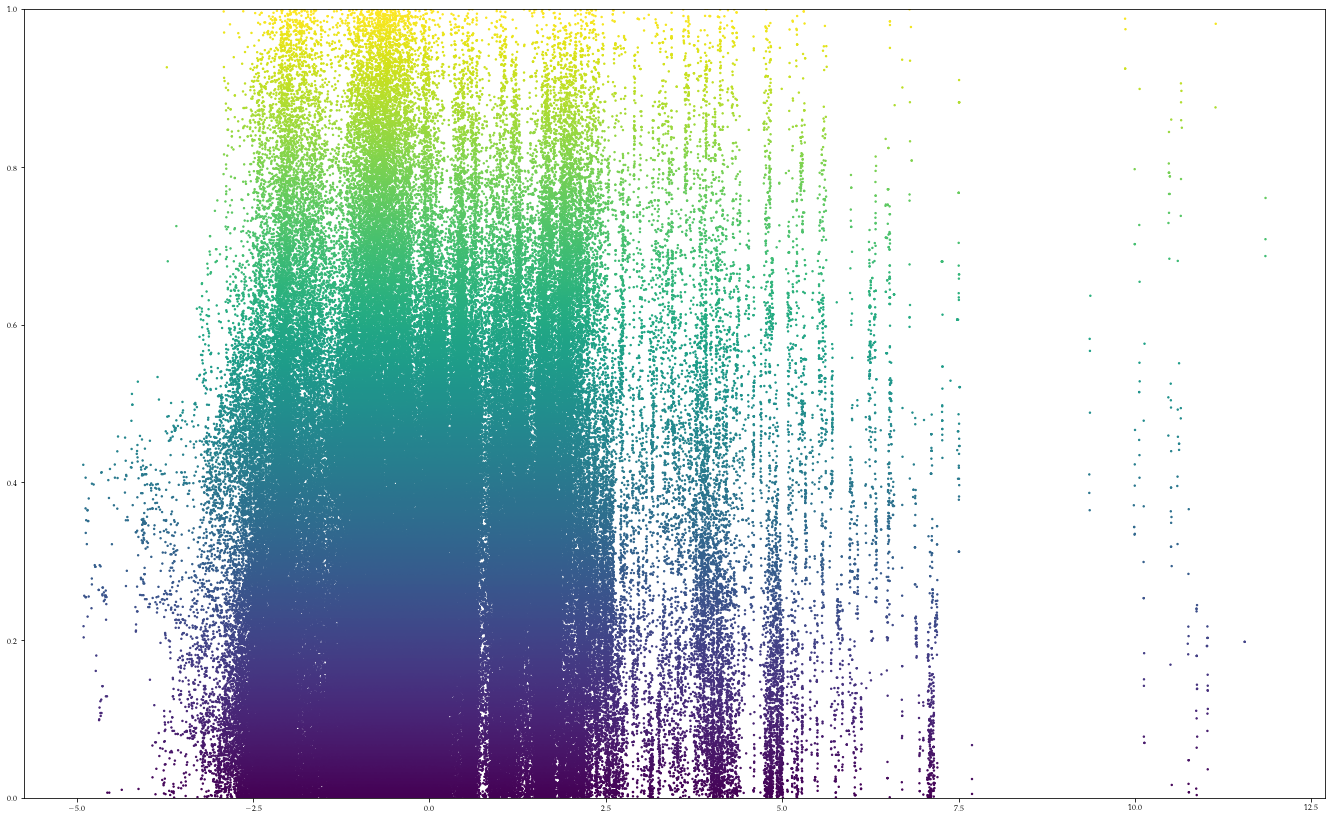

In [49]:
pcs = TruncatedSVD(n_components=1).fit_transform(x)

fig, ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs, y, c=y, s=2, vmax=1)
ax.set_ylim(0, 1)

# Bias plot of all sites

In [52]:
error_lidar_pt_vs_truth_pt(bathy_pts_df)

TypeError: error_lidar_pt_vs_truth_pt() missing 1 required positional argument: 'error_dict'